<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/ICG_transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
!pip install catboost > log.txt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
import random
torch.manual_seed(11)
np.random.seed(11)
random.seed(11)

# help function

In [2]:
from sklearn.metrics import r2_score,mean_squared_error

def mape(y_true, y_pred, e = 1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true > e
    y_true, y_pred = y_true[mask], y_pred[mask]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def show_metrics(y_real,y_pred,e=1e-8):
    res = pd.DataFrame(index=y_pred.columns,columns=['R2','MSE','MAPE'])
    for i in y_pred.columns:
        res.loc[i,'R2'] = np.clip(r2_score(y_real[i],y_pred[i]),0,1)
        res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
        res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i],e)
    res.loc['AVG'] = res.mean(axis=0)
    return res

def get_col(df,name):
  return df.columns[df.columns.str.contains(name)]

# load data

In [3]:
c = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/icg_col_names.pkl')
c.keys(),c['x'],c['y'],len(c['x']),len(c['y'])

(dict_keys(['x', 'y']),
 ['Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr',
  'Simulation Case Conditions_Feed Rate_Feed from V615 Btm    NA_wt%',
  'Simulation Case Conditions_Feed Rate_Feed from V615 Btm    Benzene_wt%',
  'Simulation Case Conditions_Feed Rate_Feed from V615 Btm    Toluene_wt%',
  'Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr',
  'Simulation Case Conditions_Feed Rate_Feed from C820 Dist    NA_wt%',
  'Simulation Case Conditions_Feed Rate_Feed from C820 Dist    Benzene_wt%',
  'Simulation Case Conditions_Feed Rate_Feed from C820 Dist    Toluene_wt%',
  'Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr',
  'Simulation Case Conditions_Feed Rate_Feed from T651    NA_wt%',
  'Simulation Case Conditions_Feed Rate_Feed from T651    Benzene_wt%',
  'Simulation Case Conditions_Feed Rate_Feed from T651    Toluene_wt%',
  'Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%',
  'Simulation Case Conditions_Spec 2 : NA in Ben

In [4]:
simmulate_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_c670.csv',index_col=0)
simmulate_df.head()

,Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr,Simulation Case Conditions_Feed Rate_Feed from V615 Btm NA_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr,Simulation Case Conditions_Feed Rate_Feed from C820 Dist NA_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr,Simulation Case Conditions_Feed Rate_Feed from T651 NA_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Toluene_wt%,Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%,Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw,Simulation Case Conditions_C620 Distillate Rate_m3/hr
001-002,163.0,1.356,10.321001,40.887009,15.0,2.338977,74.302254,17.467825,32.0,0.4524,44.244228,44.786339,90.0,980.0,0.5
001-005,163.0,1.356,10.321001,40.887009,15.0,2.338977,74.302254,17.467825,32.0,0.4524,44.244228,44.786339,90.0,950.0,1.0
001-008,163.0,1.356,10.321001,40.887009,15.0,2.338977,74.302254,17.467825,32.0,0.4524,44.244228,44.786339,90.0,920.0,1.5
001-011,163.0,1.356,10.321001,40.887009,15.0,2.338977,74.302254,17.467825,32.0,0.4524,44.244228,44.786339,80.0,980.0,0.5
001-014,163.0,1.356,10.321001,40.887009,15.0,2.338977,74.302254,17.467825,32.0,0.4524,44.244228,44.786339,80.0,950.0,1.0


In [5]:
real_df = pd.read_excel('/content/drive/MyDrive/台塑輕油案子/data/c620/明志_遷移式學習_訓練資料_寄送版/icg_data.xlsx',index_col=0)
real_df.head()

,Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr,Simulation Case Conditions_Feed Rate_Feed from V615 Btm NA_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr,Simulation Case Conditions_Feed Rate_Feed from C820 Dist NA_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr,Simulation Case Conditions_Feed Rate_Feed from T651 NA_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Toluene_wt%,Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%,Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw,Simulation Case Conditions_C620 Distillate Rate_m3/hr
2020-09-02,170.691412,1.106,10.119,36.193,13.220774,2.379,74.265,18.557,61.667779,0.449,38.5990,51.9470,83.631,763.0,0.0
2020-09-03,170.151049,1.220,10.180,36.200,13.121125,2.440,73.700,19.010,60.054792,0.428,37.9860,52.7620,92.050,816.0,0.0
2020-09-04,173.925791,1.210,10.230,36.170,12.780922,2.490,73.120,19.360,62.303892,0.426,37.3960,53.3450,89.510,736.0,0.0
2020-09-05,179.571663,1.150,10.930,36.900,12.342497,2.460,73.490,19.220,62.680651,0.492,37.0867,53.7119,88.480,748.0,0.0
2020-09-06,178.270933,1.470,11.130,36.800,12.688701,2.730,73.300,19.260,62.816413,0.501,36.8310,53.5390,88.310,774.0,0.0


# Distillate Rate_m3/hr == 0.01的部份 改成 0

In [6]:
simmulate_df.loc[simmulate_df['Simulation Case Conditions_C620 Distillate Rate_m3/hr']==0.01,'Simulation Case Conditions_C620 Distillate Rate_m3/hr'] = 0
real_df.loc[real_df['Simulation Case Conditions_C620 Distillate Rate_m3/hr']==0.01,'Simulation Case Conditions_C620 Distillate Rate_m3/hr'] = 0

# plot y dist

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


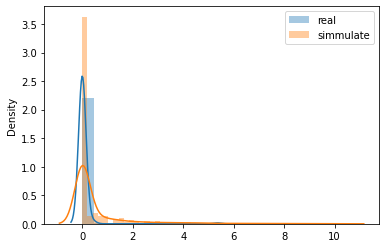

In [7]:
import seaborn as sns
sns.distplot(real_df[c['y']],label='real')
sns.distplot(simmulate_df[c['y']],label='simmulate')
plt.legend()
plt.show()

# 直接訓練 不使用模擬數據

In [8]:
from sklearn.model_selection import train_test_split
X = real_df[c['x']]
y = real_df[c['y']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

c620_icg = Pipeline([
                     ('scaler',StandardScaler()),
                     ('lr',SVR())])

c620_icg.fit(X_train,y_train)

y_real = y_test
y_pred = pd.DataFrame(c620_icg.predict(X_test),index=y_real.index,columns=y_real.columns)
show_metrics(y_real,y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,R2,MSE,MAPE
Simulation Case Conditions_C620 Distillate Rate_m3/hr,0,0.00493677,15.2938
AVG,0,0.00493677,15.2938


# 在訓練數據中加入模擬數據

In [9]:
X = real_df[c['x']]
y = real_df[c['y']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# add simmulate data to X_train ,y_train 
X_train = X_train.append(simmulate_df[c['x']])
y_train = y_train.append(simmulate_df[c['y']])

c620_icg = Pipeline([
                     ('scaler',StandardScaler()),
                     ('lr',SVR())])

c620_icg.fit(X_train,y_train)

y_real = y_test
y_pred = pd.DataFrame(c620_icg.predict(X_test),index=y_real.index,columns=y_real.columns)
show_metrics(y_real,y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,R2,MSE,MAPE
Simulation Case Conditions_C620 Distillate Rate_m3/hr,0,0.0232891,6.46749
AVG,0,0.0232891,6.46749


# ICG while 迴圈

In [10]:
def ICG(Input):
  while True:
    output = pd.DataFrame(c620_icg.predict(Input.values),index=Input.index,columns=['Simulation Case Conditions_C620 Distillate Rate_m3/hr'])
    dist_rate = output['Simulation Case Conditions_C620 Distillate Rate_m3/hr'].values[0]
    na_in_benzene = Input['Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw'].values[0]
    print('current Distillate Rate_m3/hr:{} NA in Benzene_ppmw:{}'.format(dist_rate,na_in_benzene))
    if output['Simulation Case Conditions_C620 Distillate Rate_m3/hr'].values[0] > 0:
      return output,Input
    else:
      Input['Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw'] -= 30
      print('NA in Benzene_ppmw -= 30')

In [11]:
df = simmulate_df
print(df.shape)
df = df[df['Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%']==70.0]
df = df[df['Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw']==980.0]
print(df.shape)

(1296, 15)
(122, 15)


In [12]:
for i in range(10):
  Input = df[c['x']].sample(1)
  output,Input = ICG(Input)
  print(i)

current Distillate Rate_m3/hr:-0.08175684897879343 NA in Benzene_ppmw:980.0
NA in Benzene_ppmw -= 30
current Distillate Rate_m3/hr:-0.09779943247059397 NA in Benzene_ppmw:950.0
NA in Benzene_ppmw -= 30
current Distillate Rate_m3/hr:-0.09363056834870909 NA in Benzene_ppmw:920.0
NA in Benzene_ppmw -= 30
current Distillate Rate_m3/hr:-0.0694243329930665 NA in Benzene_ppmw:890.0
NA in Benzene_ppmw -= 30
current Distillate Rate_m3/hr:-0.02745931706134952 NA in Benzene_ppmw:860.0
NA in Benzene_ppmw -= 30
current Distillate Rate_m3/hr:0.028202305888049783 NA in Benzene_ppmw:830.0
0
current Distillate Rate_m3/hr:3.0057335852995917 NA in Benzene_ppmw:980.0
1
current Distillate Rate_m3/hr:-0.077561532587203 NA in Benzene_ppmw:980.0
NA in Benzene_ppmw -= 30
current Distillate Rate_m3/hr:-0.014915368442651289 NA in Benzene_ppmw:950.0
NA in Benzene_ppmw -= 30
current Distillate Rate_m3/hr:0.0648592609420221 NA in Benzene_ppmw:920.0
2
current Distillate Rate_m3/hr:0.43201440499729893 NA in Benzene_p

# 特別資料測試

In [13]:
Input = {
'Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr': {0: 183.71834522298502},
'Simulation Case Conditions_Feed Rate_Feed from V615 Btm NA_wt%': {0: 2.06},
'Simulation Case Conditions_Feed Rate_Feed from V615 Btm Benzene_wt%': {0: 11.91},
'Simulation Case Conditions_Feed Rate_Feed from V615 Btm Toluene_wt%': {0: 37.48},
'Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr': {0: 18.599028347620738},
'Simulation Case Conditions_Feed Rate_Feed from C820 Dist NA_wt%': {0: 2.51},
'Simulation Case Conditions_Feed Rate_Feed from C820 Dist Benzene_wt%': {0: 69.02},
'Simulation Case Conditions_Feed Rate_Feed from C820 Dist Toluene_wt%': {0: 20.62},
'Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr': {0: 103.76780384010259},
'Simulation Case Conditions_Feed Rate_Feed from T651 NA_wt%': {0: 0.685},
'Simulation Case Conditions_Feed Rate_Feed from T651 Benzene_wt%': {0: 46.628},
'Simulation Case Conditions_Feed Rate_Feed from T651 Toluene_wt%': {0: 40.868},
'Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%': {0: 89.39},
'Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw': {0: 849.0}}
Input = pd.DataFrame(Input)
output,Input = ICG(Input)

current Distillate Rate_m3/hr:0.055729619627930604 NA in Benzene_ppmw:849.0


In [14]:
Input = {
'Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr': {0: 171.58942010720452},
'Simulation Case Conditions_Feed Rate_Feed from V615 Btm NA_wt%': {0: 1.971},
'Simulation Case Conditions_Feed Rate_Feed from V615 Btm Benzene_wt%': {0: 12.146},
'Simulation Case Conditions_Feed Rate_Feed from V615 Btm Toluene_wt%': {0: 37.791},
'Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr': {0: 19.669237218735567},
'Simulation Case Conditions_Feed Rate_Feed from C820 Dist NA_wt%': {0: 2.56},
'Simulation Case Conditions_Feed Rate_Feed from C820 Dist Benzene_wt%': {0: 68.421},
'Simulation Case Conditions_Feed Rate_Feed from C820 Dist Toluene_wt%': {0: 21.33},
'Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr': {0: 101.95451869681709},
'Simulation Case Conditions_Feed Rate_Feed from T651 NA_wt%': {0: 0.777},
'Simulation Case Conditions_Feed Rate_Feed from T651 Benzene_wt%': {0: 50.531},
'Simulation Case Conditions_Feed Rate_Feed from T651 Toluene_wt%': {0: 35.435},
'Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%': {0: 89.851},
'Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw': {0: 1193.0}}
Input = pd.DataFrame(Input)
output,Input = ICG(Input)

current Distillate Rate_m3/hr:0.21443081787052676 NA in Benzene_ppmw:1193.0


In [15]:
df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_c670.csv',index_col=0)
Input = df.loc['024-008',c['x']].to_frame().T
Input

,Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr,Simulation Case Conditions_Feed Rate_Feed from V615 Btm NA_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr,Simulation Case Conditions_Feed Rate_Feed from C820 Dist NA_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr,Simulation Case Conditions_Feed Rate_Feed from T651 NA_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Toluene_wt%,Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%,Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw
024-008,200.0,1.356,10.321001,40.887009,15.0,2.338977,74.302254,17.467825,92.0,0.4524,44.244236,44.786339,90.0,800.0


In [16]:
Input['Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw'] = 920
Input

,Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr,Simulation Case Conditions_Feed Rate_Feed from V615 Btm NA_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr,Simulation Case Conditions_Feed Rate_Feed from C820 Dist NA_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr,Simulation Case Conditions_Feed Rate_Feed from T651 NA_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Toluene_wt%,Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%,Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw
024-008,200.0,1.356,10.321001,40.887009,15.0,2.338977,74.302254,17.467825,92.0,0.4524,44.244236,44.786339,90.0,920


In [17]:
c620_icg.predict(Input.values)

array([0.09045253])

In [18]:
_,_ = ICG(Input)

current Distillate Rate_m3/hr:0.09045252883627464 NA in Benzene_ppmw:920


In [19]:
joblib.dump(c620_icg,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_icg_svr_real_data.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_icg_svr_real_data.pkl']